# Prevención Fuga de Clientes
El enfoque de la prevención es disminuir el impacto latente de la posibilidad de que alguno de los clientes deje de comprar productos. 
Con este fin se realiza la estrategia en 3 sentidos: <br>
**1.Motor de Recomendación** <br>
**Objetivo:** Aumentar la penetración de los productos a los clientes con el fin de fortalecer la relación comercial y su fidelización. <br>
Este enfoque hace parte de la primera parte del notebook, con el objetivo de generar un motor de recomendación con el cual se facilite la venta de nuevos productos por medio de estrategia de datos. <br>
*Notebook 1: Motor de recomendación* <br>

**2.Nueva segmentación de información con base en los datos de los clientes y sus transacciones** <br>
**Objetivo:** Generar nueva información de los clientes, con el objetivo de realizar una mejor gestión de estos y plantear estrategias con base en esta nueva característica de información desarrollada. <br>
El segundo enfoque es a través de una nueva segmentación, que permita de igual forma identificar no solo como y que es posible comprar, sino generar nuevas dimensiones de análisis, para que los equipos de business intelligence, comerciales y financieros, tengan más herramientas durante sus estrategias de negocio. <br>
*Notebook 2: Segmentación de datos* <br>

**3.Predecir la Fuga de clientes** <br>
**Objetivo:** Desarrollar un marcaje de fuga de clientes con base en la historia transaccional de cliente, permitiendo esto entrenar un modelo de Machine Learning para predecir la posible baja de clientes. <br>
El Tercer enfoque tiene dos frentes de trabajo, el primero permite establecer a través de variables de tendencias de compra y montos, si el cliente se encuentra "vivo" o no. Con base en este resultado, se activa el segundo frente, el cual a través de algoritmos de Machine Learning permite predecir la fuga de clientes con base en el marcaje realizado en la primera etapa. <br>
*Notebook 3: Predicción Fuga Clientes* <br>


### Fuente de datos
Los datos usando durante la tesis son de dominio publico y hacen referencia a un comercio de Brasil. <br>
Estos datos han sido modelados en un modelo dimensional con el fin de mejorar el performance del análisis del actual tesis y permitir generar modelos de reporting/dashboard con herramientas de BI.<br>
Los datos han sido migrados a la plataforma github con el fin que sean de dominio publico. <br>


##2.Segmentación de Clientes
Durante esta etapa se utilizará machine learning no supervisada, con el objetivo de generar segmentos de datos, los cuales apoyen a las estrategias del negocio en encontrar nuevas dimensiones de analisis para plantear su información


### 2.1 Carga de librerias y datos

In [0]:

# librerias requeridas
 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import time
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib import cm 

In [3]:
## Localización y carga de los datos
url = 'https://github.com/masdatascience/TFM-AI/blob/master/2019Tabla.xlsx?raw=true'
datos_modelo = pd.ExcelFile(url)
t1 = pd.read_excel(datos_modelo, sheet_name='table_col')
url = 'https://github.com/masdatascience/TFM-AI/blob/master/2018Tabla-1.xlsx?raw=true'
datos_modelo = pd.ExcelFile(url)
t2 = pd.read_excel(datos_modelo, sheet_name='Hoja1')
url = 'https://github.com/masdatascience/TFM-AI/blob/master/2018Tabla-2.xlsx?raw=true'
datos_modelo = pd.ExcelFile(url)
t3 = pd.read_excel(datos_modelo, sheet_name='Hoja2')



datos_facturacion = pd.concat([t1,t2,t3])




# Se elimian los datos nulos de las dimensiones importantes del analisis que son productos y clientes
datos_facturacion = datos_facturacion.dropna(subset=['ID_CLIENTE'])
datos_facturacion = datos_facturacion.dropna(subset=['ID_PRODUCTO'])
# Se elimina posibles chargeback que se presenten
datos_facturacion = datos_facturacion.loc[datos_facturacion['IMP_PRECIO_TOTAL'] > 0]
print("Datos cargados Facturación:"+str(datos_facturacion.shape))


Datos cargados Facturación:(499836, 28)


### 2.2 Preparación de los datos 
En esta sección se estarán consolidando los datos de los clientes, para identificar la cantidad de transacciones que han realizado, número de productos que han adquirido y el total de sus compras. <br>
Adicionalmente estaremos aplicando el metodo del codo para identificar una agrupación optima para aplicar posteriormente un algoritmo de machine learning no supervisado como es K-Means. 

#### 2.2.1 Información consolidad del clientes



In [14]:
# Se consolidan los datos de los clientes
informacion_cliente = datos_facturacion.groupby('ID_CLIENTE').agg({'IMP_PRECIO_TOTAL': sum,'ID_PRODUCTO': lambda x: x.nunique(),'ID_CLIENTE': lambda x: x.count()}).fillna(0)
informacion_cliente.columns = ['IMP_TOTAL_VENTAS', 'NUM_TOTAL_PRODUCTOS','NUM_TOTAL_TXN']
informacion_cliente['IMP_VENTA_PROMEDIO'] = informacion_cliente['IMP_TOTAL_VENTAS']/informacion_cliente['NUM_TOTAL_TXN']
informacion_cliente.head(2)


,IMP_TOTAL_VENTAS,NUM_TOTAL_PRODUCTOS,NUM_TOTAL_TXN,IMP_VENTA_PROMEDIO
ID_CLIENTE,,,,
0,794400.00,3,3,264800.000000
1,1131956.15,3,7,161708.021429


#### 2.2.2 Se definen funciones de clustering

In [0]:
# Se define una función que grafica el codo para identificar la mejor agrupación

def metodo_codo(datos):

  dataset =  datos.iloc[:, :].values
  estandar = StandardScaler()
  dataset= estandar.fit_transform(dataset)
  resultados = [] 
  # Se realizan una revisión de las primeras 10 agrupaciones
  for i in range(1,11): 
      kmeans = KMeans(n_clusters = i, init ='k-means++',max_iter=300,n_init=10)
      kmeans.fit(dataset)
      resultados.append(kmeans.inertia_)
  plt.plot(range(1,11) , resultados,'ro-', markersize=8, lw=2)
  plt.title('Metodo del codo')
  plt.xlabel('Número de agrupaciones de clientes')
  plt.ylabel('WCSS')
  plt.show()
 

  
# Función que grafica los clusters
def graficarCluster(datos, campo1, campo2, titulo, eje_x, eje_y):
  plt.scatter(datos.loc[datos['DATA_SEG'] == 0][campo1], datos.loc[datos['DATA_SEG'] == 0][campo2], c='blue')
  plt.scatter(datos.loc[datos['DATA_SEG'] == 1][campo1], datos.loc[datos['DATA_SEG'] == 1][campo2], c='red' )
  plt.scatter(datos.loc[datos['DATA_SEG'] == 2][campo1], datos.loc[datos['DATA_SEG'] == 2][campo2],c='orange')
  plt.scatter(datos.loc[datos['DATA_SEG'] == 3][campo1], datos.loc[datos['DATA_SEG'] == 3][campo2],c='green')
  plt.scatter(datos.loc[datos['DATA_SEG'] == 4][campo1], datos.loc[datos['DATA_SEG'] == 4][campo2],c='yellow')
  plt.scatter(datos.loc[datos['DATA_SEG'] == 5][campo1], datos.loc[datos['DATA_SEG'] == 5][campo2],c='black')
  plt.title(titulo)
  plt.xlabel(eje_x)
  plt.ylabel(eje_y)
  plt.grid()
  plt.show()

# Se aplica el metodo de la silueta
def metodo_silueta(datos):
  
  for num_cluster in [3,4,5,6,7,8]:
      kmeans = KMeans(n_clusters=num_cluster).fit(datos)
      silhouette_avg = silhouette_score(datos,kmeans.labels_ )

      print('Scoring silueta para %i Clusters: %0.4f' % (num_cluster, silhouette_avg))
      
 
 

### 2.3 Identificar mejor segmentación por clustering para clientes 
Se aplicarán dos enfoques, el primero el metodo del codo y se comprobará con base en la silueta



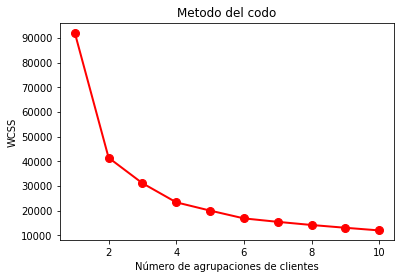

Scoring silueta para 3 Clusters: 0.3527
Scoring silueta para 4 Clusters: 0.3762
Scoring silueta para 5 Clusters: 0.3462
Scoring silueta para 6 Clusters: 0.3414
Scoring silueta para 7 Clusters: 0.3129
Scoring silueta para 8 Clusters: 0.3044


In [16]:
# Normalizo los datos previo a realizar la revisión 
ranking_cliente = informacion_cliente.rank(method='first')
cliente_normalizado = (ranking_cliente - ranking_cliente.mean()) / ranking_cliente.std()

# Aplico metodo del codo - su resultado es 4
metodo_codo(cliente_normalizado)

# Compruebo con silueta
metodo_silueta(cliente_normalizado)
# Con los valores definidos entre el metodo del codo y silueta se realizará la segmentación con K-means - Su resultado brinda K=4

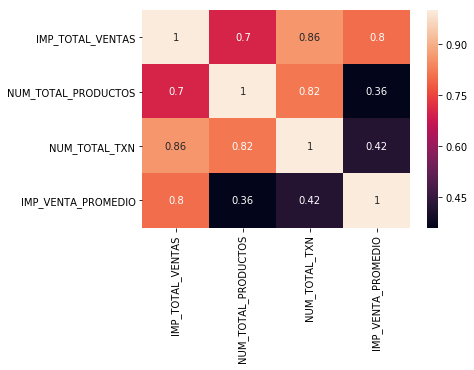

In [17]:
# Se pueden visualizar las correlaciones en la información normalizada
data_correlaciones = cliente_normalizado.corr()
sns.heatmap(data_correlaciones, annot = True) 
plt.show() 

### 2.3 Se crea la nueva segmentación de datos
Con base en los resultados realizados en los anteriores pasos, se realiza la segmentación de datos, la cual se integra al modelo de datos.

In [18]:
#se geneará el campo de segmentación DATA_SEG con la cantidad de clusters definidos en el anterior paso
clusters=4
# Se desactiva la opcion de verbose para no visualizar las iteraciones. Para activar verbose=1
kmeans = KMeans(n_clusters=clusters,init='k-means++', n_init=100).fit(cliente_normalizado)
cliente_normalizado['DATA_SEG'] = kmeans.labels_
# Se visualiza la cantidad de clientes por el nuevo Campo
print(str(cliente_normalizado.groupby('DATA_SEG').count()['IMP_TOTAL_VENTAS']))

DATA_SEG
0    4793
1    6537
2    6593
3    5115
Name: IMP_TOTAL_VENTAS, dtype: int64


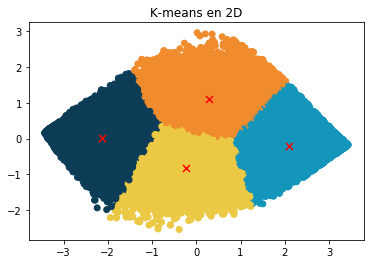

In [19]:
# Ahora se grafica los segmentos 
# Para ello se procede a realizar una reduccion dimensional con PCA
reductor = PCA(n_components=2)
datos_2d = reductor.fit_transform(cliente_normalizado.drop(['DATA_SEG'],axis=1).values)
# Se ajusta el algoritmo con los datos
kmeans.fit(datos_2d)
# Se obtienen descriptores y se definen colores de las agrupaciones
labels = kmeans.labels_
colores = ['#1496BB','#0D3D56','#EBC944','#F08C2D']
col_map=dict(zip(set(labels),colores))
label_color = [col_map[l] for l in labels];
# Se realiza el plot del grafico
fig, ax = plt.subplots()
ax.scatter(datos_2d[:,0], datos_2d[:,1], c=label_color);
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', s=50, c='r');
plt.title('K-means en 2D');


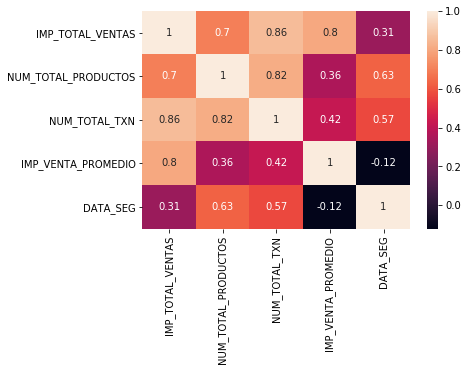

In [20]:
#Se puede visualizar nuevamente las correlaciones ahora con el segmento de datos 
sns.heatmap(cliente_normalizado.corr(), annot = True) 
plt.show() 

In [21]:
# Se define los clientes con mayor valor de ventas
clientes_compras_altas = (cliente_normalizado.loc[cliente_normalizado['DATA_SEG'] == 3]).sort_values(ascending=False,by='IMP_TOTAL_VENTAS')
informacion_cliente.loc[clientes_compras_altas.index].describe()

,IMP_TOTAL_VENTAS,NUM_TOTAL_PRODUCTOS,NUM_TOTAL_TXN,IMP_VENTA_PROMEDIO
count,5.115000e+03,5115.000000,5115.000000,5115.000000
mean,5.583673e+05,3.807038,12.508895,50412.708437
std,5.176179e+05,2.147228,15.736901,25477.929705
min,2.176800e+04,1.000000,2.000000,3280.500000
25%,1.984085e+05,3.000000,5.000000,31203.944444
50%,3.945080e+05,3.000000,8.000000,46728.000000
75%,7.559840e+05,5.000000,15.000000,65043.322857
max,8.364696e+06,53.000000,408.000000,155169.000000


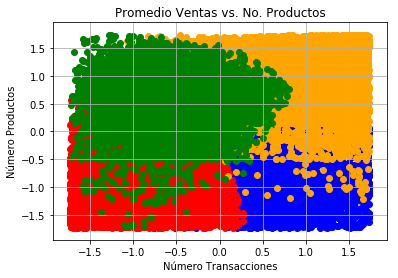

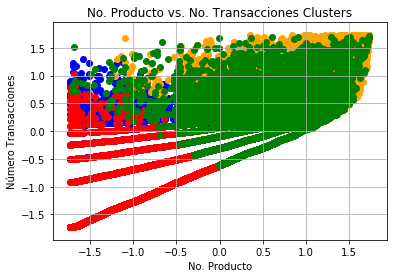

In [22]:
# se visualiza la distribución entre la información 
col1='NUM_TOTAL_TXN'
col2='IMP_TOTAL_VENTAS'
col3='IMP_VENTA_PROMEDIO'
col4='NUM_TOTAL_PRODUCTOS'

graficarCluster(cliente_normalizado,col3,col4,'Promedio Ventas vs. No. Productos','Número Transacciones','Número Productos') # clustering cantidad vs promedio de facturación
graficarCluster(cliente_normalizado,col4,col1,'No. Producto vs. No. Transacciones Clusters','No. Producto','Número Transacciones') # clustering cantidad vs promedio de facturación

In [23]:
# Se define los clientes con mayor valor de ventas
clientes_compras_altas = (cliente_normalizado.loc[cliente_normalizado['DATA_SEG'] == 3]).sort_values(ascending=False,by='IMP_TOTAL_VENTAS')
informacion_cliente.loc[clientes_compras_altas.index].describe()

,IMP_TOTAL_VENTAS,NUM_TOTAL_PRODUCTOS,NUM_TOTAL_TXN,IMP_VENTA_PROMEDIO
count,5.115000e+03,5115.000000,5115.000000,5115.000000
mean,5.583673e+05,3.807038,12.508895,50412.708437
std,5.176179e+05,2.147228,15.736901,25477.929705
min,2.176800e+04,1.000000,2.000000,3280.500000
25%,1.984085e+05,3.000000,5.000000,31203.944444
50%,3.945080e+05,3.000000,8.000000,46728.000000
75%,7.559840e+05,5.000000,15.000000,65043.322857
max,8.364696e+06,53.000000,408.000000,155169.000000


In [24]:
# Se define los clientes con mayor valor de ventas
clientes_compras_bajas = (cliente_normalizado.loc[cliente_normalizado['DATA_SEG'] == 0]).sort_values(ascending=False,by='IMP_TOTAL_VENTAS')
informacion_cliente.loc[clientes_compras_bajas.index].describe()

,IMP_TOTAL_VENTAS,NUM_TOTAL_PRODUCTOS,NUM_TOTAL_TXN,IMP_VENTA_PROMEDIO
count,4.793000e+03,4793.000000,4793.000000,4.793000e+03
mean,1.031397e+06,1.469226,3.496766,3.163790e+05
std,3.580956e+06,0.637862,3.430024,1.023533e+06
min,7.899200e+04,1.000000,1.000000,3.619460e+04
25%,1.903025e+05,1.000000,1.000000,1.026415e+05
50%,3.798480e+05,1.000000,2.000000,1.399058e+05
75%,8.158780e+05,2.000000,4.000000,2.535712e+05
max,1.171403e+08,4.000000,38.000000,3.220000e+07


In [26]:
from google.colab import files
informacion_cliente.to_csv('filename.csv') 
files.download('filename.csv')

MessageError: ignored

In [30]:
cliente_normalizado

,IMP_TOTAL_VENTAS,NUM_TOTAL_PRODUCTOS,NUM_TOTAL_TXN,IMP_VENTA_PROMEDIO,DATA_SEG
ID_CLIENTE,,,,,
0,0.376580,0.144573,-0.506793,1.160414,0
1,0.555811,0.144723,0.218701,0.837438,0
2,0.753837,1.665779,1.456626,-0.930061,3
5,-0.348763,-1.731938,0.100066,-0.814282,1
8,0.326961,1.498276,0.607986,-0.241556,3
9,0.874427,0.144873,0.608137,0.953367,2
14,-1.395128,-1.731788,-1.731938,-1.140416,1
18,1.173345,1.498427,1.362350,0.503034,2
19,0.178253,-0.494464,-0.040673,0.446799,0


In [0]:
from google.colab import files
#Exporto el resultado
cliente_normalizado.to_csv('clientes_segmentos.csv')
# verifico el archivo !dir
files.download('clientes_segmentos.csv')